In [1]:
import os
import gc
import glob
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
#import climpred
#from climpred import HindcastEnsemble
from functools import partial
import xarray as xr
import flox
from eofs.xarray import Eof
import xesmf as xe
import xskillscore as xs
import readnc_tools as rd
import readnc2_tools as rd2
import plot_tools as pt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#path_temp="/cnrm/pastel/DATA/REF/era5/ncdf/daily/"
path_temp="/media/ardilouzec/SAVE/ERA5/"
#path_snow="/cnrm/pastel/USERS/ardilouzec/obs/era5_land/"
#path_temp="/cnrm/pastel/DATA/REF/era5/ncdf/daily/"
path_snow="/media/ardilouzec/SAVE/ERA5-Land/"
#path_ao="/cnrm/pastel/USERS/ardilouzec/obs/NAO_AO_INDEX_NOAA/"
path_ao="/media/ardilouzec/SAVE/NAO_AO_INDEX_NOAA/"
lat_lims = [30,90]

In [13]:
#Loading daily ERA5 T2M from 1993 to 2018
ref='era5'
variables=['t2m','z500','sst']
min_lat=40 ; max_lat=53; min_lon=110; max_lon=140 #China/Russia
temp0=rd.read_ref(path_temp,variables,ref).sel(lat=slice(-30,90),lon=slice(0,360))
temp0=temp0.sel(time=temp0.time.dt.month.isin([1,2,3,4]))

#Compute daily anomalies
temp0=(temp0.groupby("time.dayofyear")-temp0.groupby("time.dayofyear").mean("time")).compute()
# select the grid points inside the red box (North China/South-East Russia) and perform spatial averaging
temp=temp0.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon)).mean(["lat","lon"]).compute()

In [14]:
#Loading daily ERA5Land Snow depth Water equivalent from 1993 to 2018 (February to May only)
ref='era5land'
variables=['sd']
sn=rd.read_ref(path_snow,variables,ref)
#Compute daily anomalies     
sn=sn.groupby("time.dayofyear")-sn.groupby("time.dayofyear").mean("time")

In [4]:
#Loading daily NAO from 1979 to 2018
dfa=pd.read_csv(path_ao+'NOAA_AO_index_1950_2023.txt', sep=' ',names=['time','AO index'],parse_dates=[0])
dfn=pd.read_csv(path_ao+'NOAA_NAO_index_1950_2020.txt', sep=' ',names=['time','NAO index'],parse_dates=[0])
df=dfa.merge(dfn).to_xarray().set_coords('time').swap_dims({'index':'time'}).drop_vars(['index']).sel(time=slice('1979','2018'))
df=df.groupby("time.dayofyear")-df.groupby("time.dayofyear").mean("time")
print(df)

<xarray.Dataset>
Dimensions:    (time: 14610)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    AO index   (time) float64 -1.362 -1.41 -1.688 ... 0.6084 0.3429 0.3218
    NAO index  (time) float64 -0.9753 -1.01 -0.6929 ... -0.04055 -0.5414 -0.8243


In [15]:
sn=sn.reindex({"time":temp.time}).sel(lat=slice(30,90),lon=slice(0,360))
sn=sn.sel(time=sn.time.dt.month.isin([2,3,4])).compute()
#Rename sd to snow to avoid a confusion between sd (=snow depth) and std (standard deviation) 
sn=sn.rename({'sd':'snow'})
#print(sn)

In [16]:
temp0.z500.to_netcdf(path="/home/ardilouzec/tmp/z500_anomaly_for_Angel.nc",encoding={'time':{'dtype':'double'}})
temp0.sst.to_netcdf(path="/home/ardilouzec/tmp/sst_anomaly_for_Angel.nc",encoding={'time':{'dtype':'double'}})
sn.snow.to_netcdf(path="/home/ardilouzec/tmp/snow_anomaly_for_Angel.nc",encoding={'time':{'dtype':'double'}})

In [13]:
#For each predictor: select the time window consistent with the 4 consecutive S2S initialization dates (btwn 27 Feb.and 19 March)
snmonth=sn.snow.where(((sn.time.dt.month==2)&(sn.time.dt.day>=27))|((sn.time.dt.month==3)&(sn.time.dt.day<=19)))
snmonth=snmonth.dropna(dim='time',how='all')
z500month=temp0.z500.where(((temp0.time.dt.month==2)&(temp0.time.dt.day>=27))|((temp0.time.dt.month==3)&(temp0.time.dt.day<=19))).dropna(dim='time',how='all')
sstmonth=temp0.sst.where(((temp0.time.dt.month==2)&(temp0.time.dt.day>=27))|((temp0.time.dt.month==3)&(temp0.time.dt.day<=19))).dropna(dim='time',how='all')
naomonth=df['NAO index'].where(((df.time.dt.month==2)&(df.time.dt.day>=27))|((df.time.dt.month==3)&(df.time.dt.day<=19))).dropna(dim='time',how='all')

#For the predictand: select the corresponding time window comprised between 24 March and 13 April (=Week3+Week4 after initialization)
t2mmonth=temp.t2m.where(((temp.time.dt.month==3)&(temp.time.dt.day>=24))|((temp.time.dt.month==4)&(temp.time.dt.day<=13))).dropna(dim='time',how='all')


In [14]:
#time-average year by year
snmonth=snmonth.groupby('time.year').mean('time')
z500month=z500month.groupby('time.year').mean('time')
sstmonth=sstmonth.groupby('time.year').mean('time')
naomonth=naomonth.groupby('time.year').mean('time')
t2mmonth=t2mmonth.groupby('time.year').mean('time')

In [15]:
#remove linear trend from the time series
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
snmonth=detrend_dim(snmonth,dim='year').rename('sn')
z500month=detrend_dim(z500month,dim='year').rename('z500')
sstmonth=detrend_dim(sstmonth,dim='year').rename('sst')
naomonth=detrend_dim(naomonth,dim='year').rename('NAO')
t2mmonth=detrend_dim(t2mmonth,dim='year').rename('t2m')

In [16]:
print('Lagged Pearson Corr. NAO index vs T2m China:'+str(np.round(xs.pearson_r(naomonth,t2mmonth).values,2)))
print('Lagged Spearman Corr. NAO index vs T2m China:'+str(np.round(xs.spearman_r(naomonth,t2mmonth).values,2)))

Lagged Pearson Corr. NAO index vs T2m China:0.34
Lagged Spearman Corr. NAO index vs T2m China:0.33


/home/ardilouzec/mambaforge/envs/climpred/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/mambaforge/envs/climpred/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/ardilouzec/mambaforge/envs/climpred/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/mambaforge/envs/climpred/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/mambaforge/envs/climpred/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warn

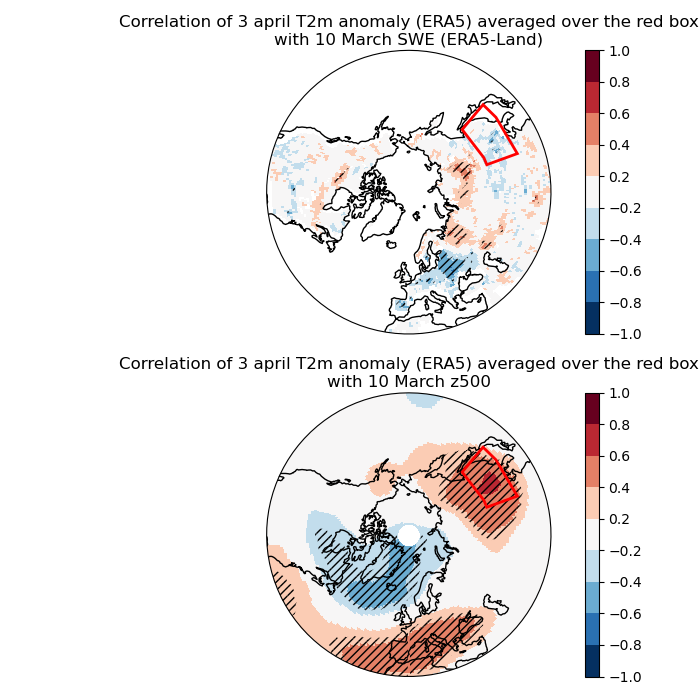

/home/ardilouzec/mambaforge/envs/climpred/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


Text(0.5, 1.0, 'Correlation of 3 april T2m anomaly (ERA5) averaged over the red box with 10 March sst')

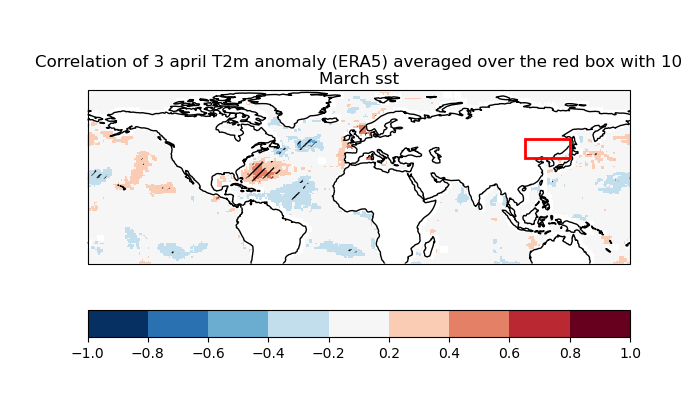

In [27]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
#between yearly averages of 17 Feb to 18 March snow and 18March to 15April Red box 2m Temperature 
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
#levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels = [np.round(x,2) for x in np.arange(-1,1.2,0.2) ]
levels.remove(0)
fig,axs = plt.subplots(nrows=2,figsize=(7, 7), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
p=xs.pearson_r(snmonth,t2mmonth,dim='year').sel(lat=slice(0,80)).plot(ax=axs[0],x='lon',y='lat',levels=levels,extend=None,transform=ccrs.PlateCarree())
s=xs.pearson_r_eff_p_value(snmonth,t2mmonth,dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[255, 39], width=50, height=21, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[min_lon, min_lat], width=(max_lon-min_lon), height=(max_lat-min_lat), facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
p.axes.set_title("Correlation of 3 april T2m anomaly (ERA5) averaged over the red box with 10 March SWE (ERA5-Land)",loc='center',wrap=True)

p=xs.pearson_r(z500month,t2mmonth,dim='year').sel(lat=slice(0,90)).plot(ax=axs[1],x='lon',y='lat',levels=levels,extend=None,transform=ccrs.PlateCarree())
s=xs.pearson_r_eff_p_value(z500month,t2mmonth,dim='year').sel(lat=slice(0,90))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[255, 39], width=50, height=21, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[min_lon, min_lat], width=(max_lon-min_lon), height=(max_lat-min_lat), facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
p.axes.set_title("Correlation of 3 april T2m anomaly (ERA5) averaged over the red box with 10 March z500",loc='center',wrap=True)
plt.tight_layout()
plt.show()


fig = plt.figure(figsize =(7, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
p=xs.pearson_r(sstmonth,t2mmonth,dim='year').sel(lat=slice(-30,90)).plot(ax=ax,x='lon',y='lat',levels=levels,extend=None,transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
s=xs.pearson_r_eff_p_value(sstmonth,t2mmonth,dim='year').sel(lat=slice(-30,90))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
#pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[255, 39], width=50, height=21, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[min_lon, min_lat], width=(max_lon-min_lon), height=(max_lat-min_lat), facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
p.axes.set_title("Correlation of 3 april T2m anomaly (ERA5) averaged over the red box with 10 March sst",loc='center',wrap=True)



In [29]:
#EOFS : extract daily values compatible with initialization dates
snmonth=sn.snow.where(((sn.time.dt.month==2)&(sn.time.dt.day>=27))|((sn.time.dt.month==3)&(sn.time.dt.day<=19))).dropna(dim='time',how='all')
z500month=temp0.z500.where(((temp0.time.dt.month==2)&(temp0.time.dt.day>=27))|((temp0.time.dt.month==3)&(temp0.time.dt.day<=19))).dropna(dim='time',how='all')
sstmonth=temp0.sst.where(((temp0.time.dt.month==2)&(temp0.time.dt.day>=27))|((temp0.time.dt.month==3)&(temp0.time.dt.day<=19))).dropna(dim='time',how='all')

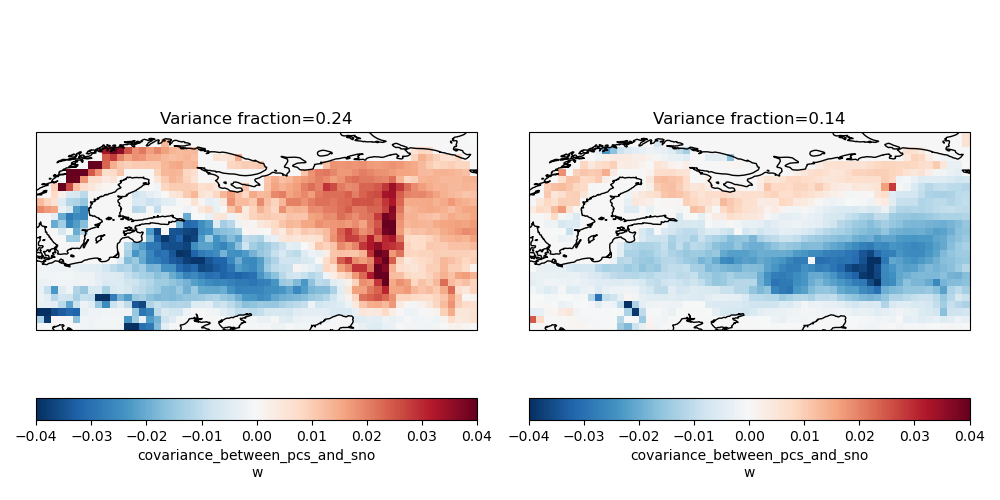

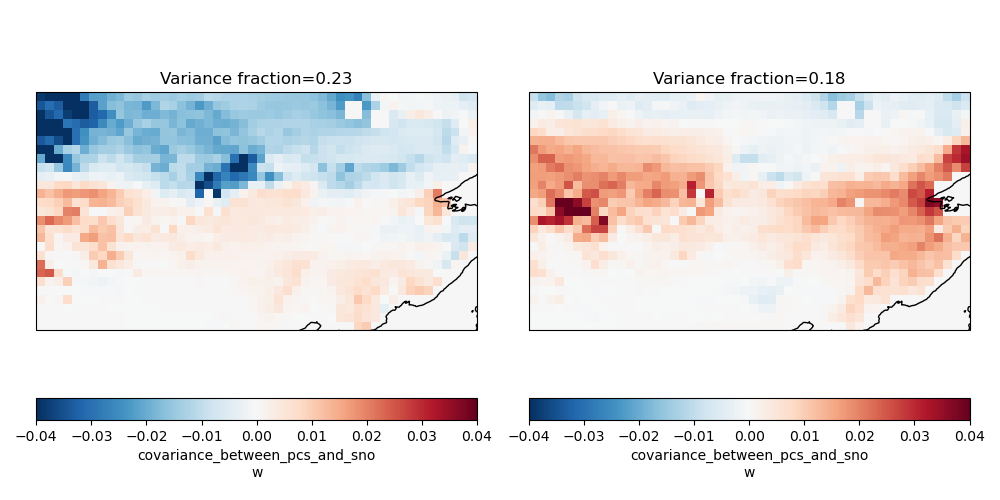

In [78]:
levels = [np.round(x,2) for x in np.arange(-1,1.2,0.1) ]
levels = [np.round(x,3) for x in np.arange(-0.04,0.05,0.005) ]
levels.remove(0)
lats=[slice(45,72),slice(40,67)];lons=[slice(10,70),slice(90,140)]
solvers_snow=[]
for rangelat,rangelon in zip(lats,lons):
 sneof=snmonth.sel(lat=rangelat,lon=rangelon).fillna(0)
#sneofUS=snmonth.snow.sel(lat=slice(45,65),lon=slice(245,285))
 coslat= np.cos(np.deg2rad(sneof.coords['lat'].values)).clip(0., 1.)
 wgts = np.sqrt(coslat)[..., np.newaxis]
 solversn=Eof(sneof,weights=wgts,center=True)
 eofs=solversn.eofsAsCovariance(neofs=3)
 expl_var=solversn.varianceFraction(neigs=3)
 fig,axs = plt.subplots(ncols=2,figsize=(10, 5),subplot_kw=dict(projection=ccrs.PlateCarree()))
 p=eofs[0].plot(ax=axs[0],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
 axs[0].set_title('Variance fraction='+str(np.round(expl_var[0].values,2)))
 p.set_clim(-0.04, 0.04)
 #pcs=solver.pcs(npcs=3)
 p=eofs[1].plot(ax=axs[1],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
 axs[1].set_title('Variance fraction='+str(np.round(expl_var[1].values,2)))
 p.set_clim(-0.04, 0.04)
 [ax.coastlines() for ax in axs.flatten()]
 plt.tight_layout()
 solvers_snow.append(solversn)


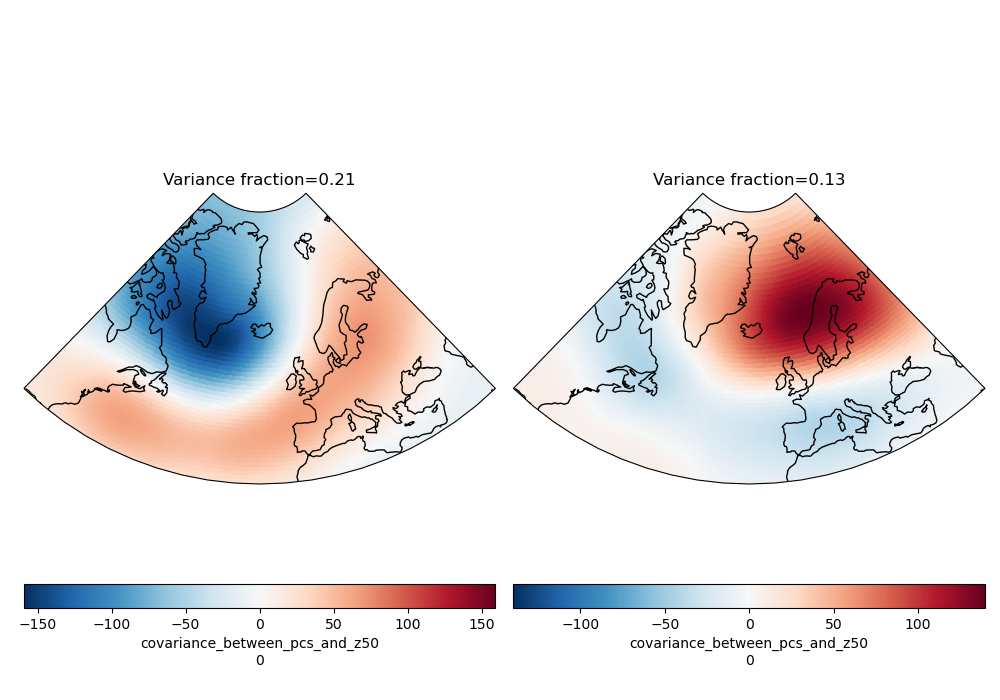

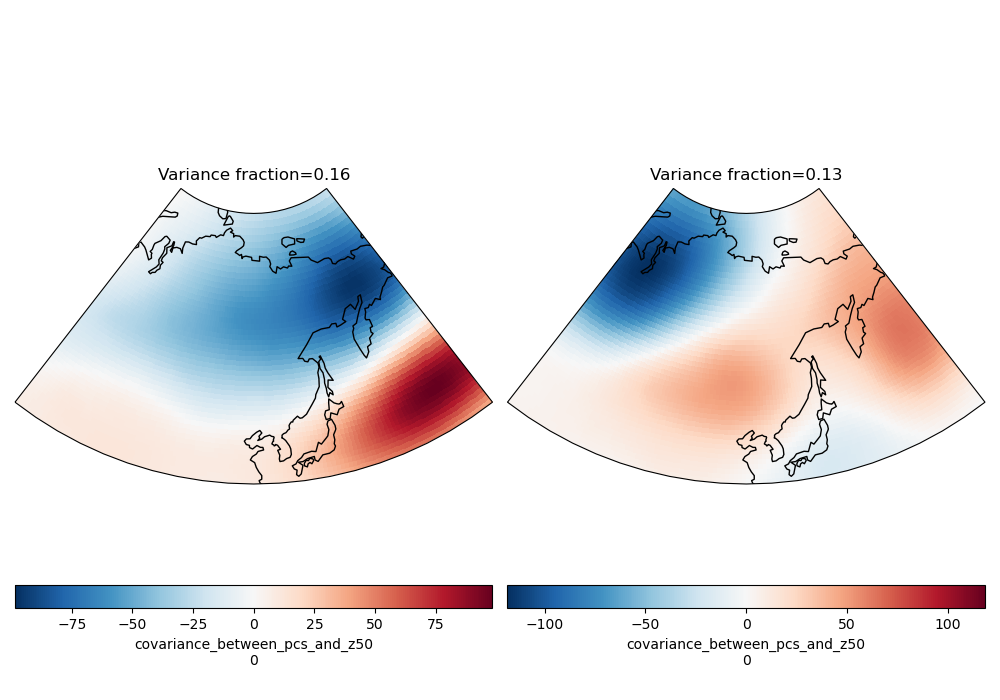

In [79]:
import matplotlib.path as mpath
##### EOF for Z500
lats=[slice(30,85),slice(30,80)];lons=[slice(-90,50),slice(60,180)]
solvers_z=[]
for rangelat,rangelon in zip(lats,lons):
    
 coslat= np.cos(np.deg2rad(z500month.sel(lat=rangelat).coords['lat'].values)).clip(0., 1.)
 wgts = np.sqrt(coslat)[..., np.newaxis]
 z500month.coords['lon']= (z500month.coords['lon'] + 180) % 360 - 180
 z500month=z500month.sortby(z500month.lon)
 solverz=Eof(z500month.sel(lon=rangelon,lat=rangelat),weights=wgts)
 #solverz=Eof(z500month.sel(lon=slice(-90,90)),weights=wgts)
 eofs=solverz.eofsAsCovariance(neofs=3)
 expl_var=solverz.varianceFraction(neigs=3)
 #fig,axs = plt.subplots(ncols=2,figsize=(10, 7),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
 fig,axs = plt.subplots(ncols=2,figsize=(10, 7),subplot_kw=dict(projection=ccrs.LambertConformal(central_longitude=(rangelon.start+rangelon.stop)/2, central_latitude=60.0)))
 p=eofs[0].plot(ax=axs[0],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
 axs[0].set_title('Variance fraction='+str(np.round(expl_var[0].values,2)))
 #pt.polarCentral_set_latlim(lat_lims,axs[0])
 #pcs=solver.pcs(npcs=3)
 p=eofs[1].plot(ax=axs[1],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
 axs[1].set_title('Variance fraction='+str(np.round(expl_var[1].values,2)))
 #pt.polarCentral_set_latlim(lat_lims,axs[1])
 [ax.coastlines() for ax in axs.flatten()]
 xlim = [rangelon.start, rangelon.stop]
 ylim = [rangelat.start, rangelat.stop]
 lower_space = 10 
 rect = mpath.Path([[xlim[0], ylim[0]],
                   [xlim[1], ylim[0]],
                   [xlim[1], ylim[1]],
                   [xlim[0], ylim[1]],
                   [xlim[0], ylim[0]],
                   ]).interpolated(20)
 proj_to_data   = ccrs.PlateCarree()._as_mpl_transform(axs[1]) - axs[1].transData
 rect_in_target = proj_to_data.transform_path(rect)
 [ax.set_boundary(rect_in_target) for ax in axs.flatten()]
#[ax.set_extent([xlim[0], xlim[1], ylim[0] - lower_space, ylim[1]]) for ax in axs.flatten()]
#[ax.set_extent([-90, 170, 30, 85], ccrs.AlbersEqualArea(central_longitude=45, central_latitude=60)) for ax in axs.flatten()]
#[ax.set_extent([-90, 170, 30, 85], ccrs.PlateCarree()) for ax in axs.flatten()]
#pt.polarCentral_set_latlim(lat_lims,p.axes)
 plt.tight_layout()
 solvers_z.append(solverz)


# Correlation between snow pc1 and z500 pc1

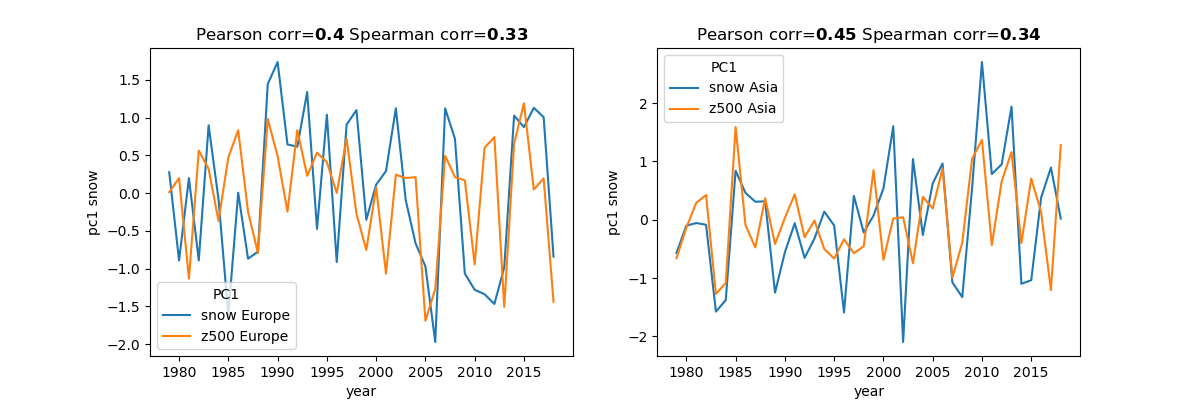

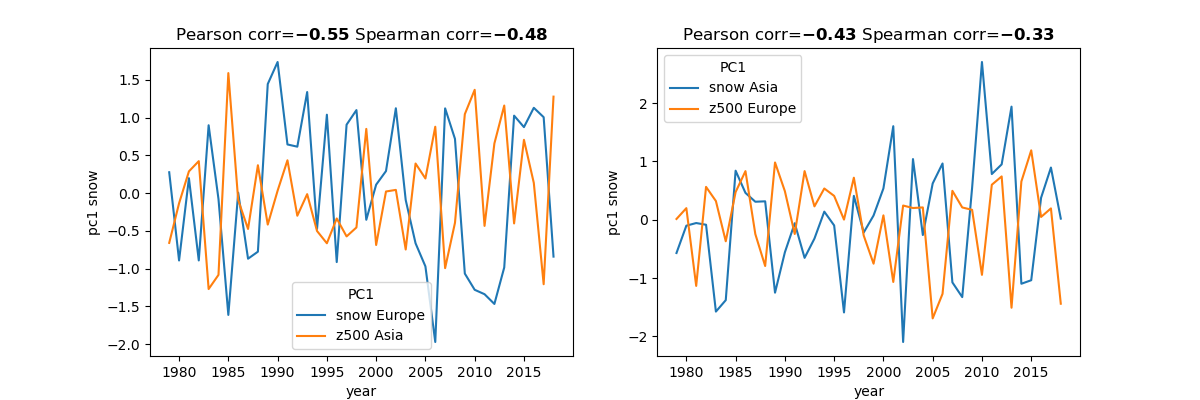

In [162]:
def plotPC(k,l):
 fig,axs = plt.subplots(ncols=2,figsize=(12, 4))
 loc=['Europe','Asia']
 for i,j in zip([0,1],[k,l]):
  pc1snow,pc1z500=solvers_snow[i].pcs(npcs=3, pcscaling=1),solvers_z[j].pcs(npcs=3, pcscaling=1)
  toto=xr.concat([pc1snow[:,0].rename('pc1 snow'),pc1z500[:,0].rename('pc1 z500')],dim=pd.Index(['snow '+loc[i],'z500 '+loc[j]],name='PC1'))
  toto=toto.groupby('time.year').mean('time')
  toto.plot.line(ax=axs[i],hue='PC1',add_legend=True)
  
  bootdata=xs.resample_iterations_idx(toto, 2000, 'year')
  corr=[]
  for method in [xs.pearson_r,xs.spearman_r]:
   corrtmp=str(np.round(method(toto.sel({'PC1':'snow '+loc[i]}),toto.sel({'PC1':'z500 '+loc[j]}),dim='year').values,2))
   q95=method(bootdata.sel({'PC1':'snow '+loc[i]}),bootdata.sel({'PC1':'z500 '+loc[j]}),dim='year').quantile(0.95).values
   q5=method(bootdata.sel({'PC1':'snow '+loc[i]}),bootdata.sel({'PC1':'z500 '+loc[j]}),dim='year').quantile(0.05).values
   if q95*q5 > 0 :
    corrtmp=r"$\bf{" + corrtmp + "}$"
   corr.append(corrtmp) 
  axs[i].set_title('Pearson corr='+corr[0]+' Spearman corr='+corr[1])
plotPC(0,1)
plotPC(1,0)



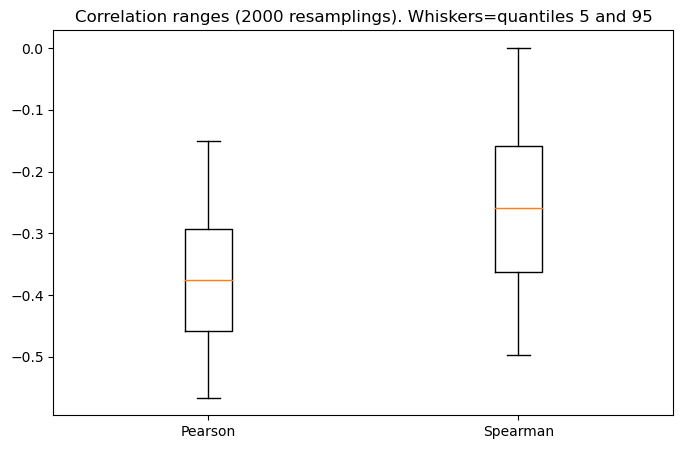

In [29]:
# Correlations after bootstrapping
#data=xr.merge([pcsn.groupby('time.year').mean('time').rename('pcSnow'),pcz.groupby('time.year').mean('time').rename('pcZ')])
#bootdata=xs.resample_iterations_idx(data, 2000, 'year')
#pearson_range=xs.pearson_r(bootdata.pcSnow,bootdata.pcZ,dim='year')
#spearman_range=xs.spearman_r(bootdata.pcSnow,bootdata.pcZ,dim='year')
#fig = plt.figure(figsize =(8, 5))
#plt.boxplot([pearson_range,spearman_range],whis=(5,95),showfliers=False,labels=['Pearson','Spearman'])
#plt.title('Correlation ranges (2000 resamplings). Whiskers=quantiles 5 and 95')
#plt.show()

# Lagged correlation of t2m averaged over China (24 March-13 April) and pc1 of snow and z500 (27 Feb. - 19 March)

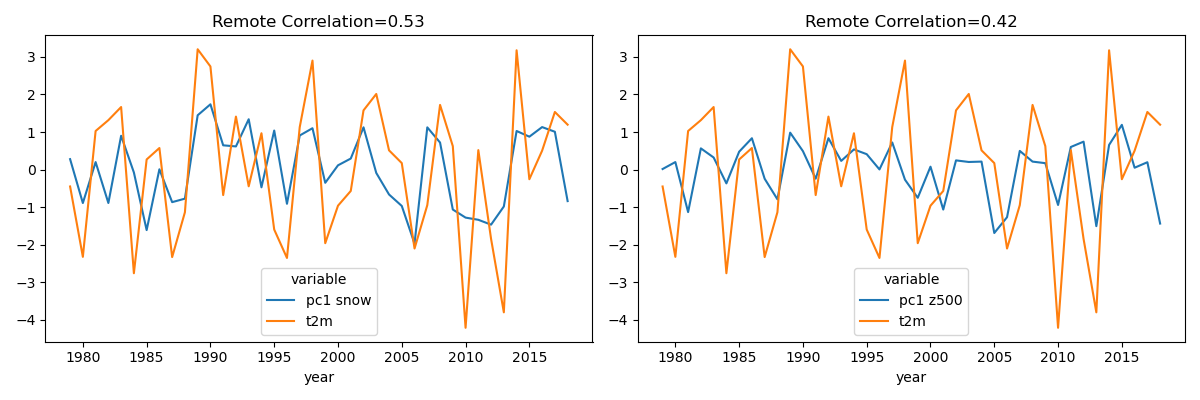

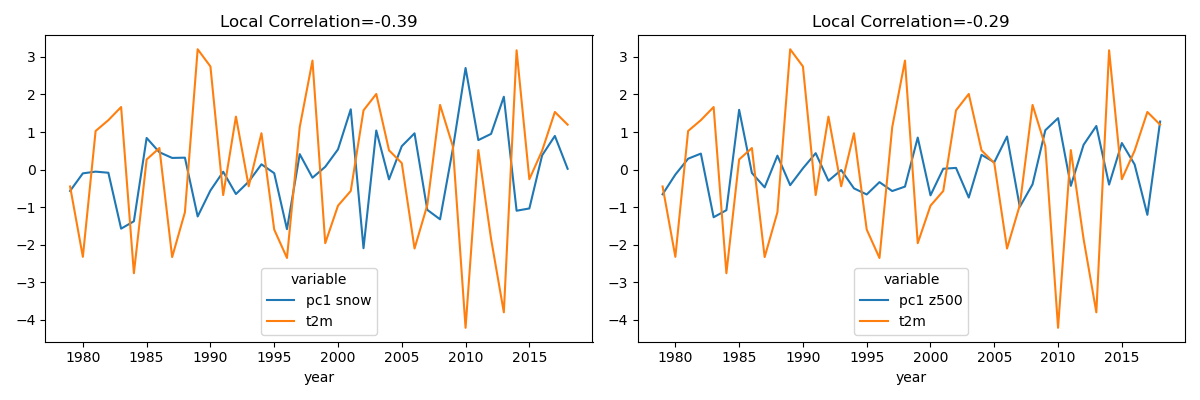

In [167]:
#we select 30-day rolling mean temperature time series at 15 Aprils (= averaged over the 30 day period 18 March-15-April) 
#temp1=temp1.where((temp1.time.dt.month==4)&(temp1.time.dt.day==15))
#we correlate yearly averages of the Principal component time series of EOF1 and the temperature index
loc=['Remote','Local']
for i in [0,1]:
 pc1snow,pc1z500=solvers_snow[i].pcs(npcs=3, pcscaling=1),solvers_z[i].pcs(npcs=3, pcscaling=1)
 pcsn,pcz=pc1snow[:,0].rename('pc1 snow'),pc1z500[:,0].rename('pc1 z500')  
 c=xr.corr(t2mmonth,pcsn.groupby('time.year').mean('time'))
 c2=xr.corr(t2mmonth,pcz.groupby('time.year').mean('time'))
#c3=xr.corr(temp1.msl,a.groupby('time.year').mean('time'))
#c3=xr.corr(temp1.z500,index['AO index'])
#c4=xr.corr(a.groupby('time.year').mean('time'),index['AO index'])
 fig,axs = plt.subplots(ncols=2,figsize=(12, 4))
 t=xr.combine_by_coords([t2mmonth,pcsn.groupby('time.year').mean('time')])
 t.to_array().plot.line(ax=axs[0],x='year')
 axs[0].set_title(str(loc[i])+" Correlation="+str(np.round(c.values,2)))
#Normalization to unit variance for z500 time series
#ts=(temp1.z500 - temp1.z500.mean('year'))/temp1.z500.std('year')
 t=xr.combine_by_coords([t2mmonth,pcz.groupby('time.year').mean('time')])
 t.to_array().plot.line(ax=axs[1],x='year')
 axs[1].set_title(str(loc[i])+" Correlation="+str(np.round(c2.values,2)))
#mslp
#ts=(temp1.msl - temp1.msl.mean('year'))/temp1.msl.std('year')
#t=xr.combine_by_coords([ts,a.groupby('time.year').mean('time')])
#t.rename({'pcs':'snow PC1'}).to_array().plot.line(ax=axs[2],x='year')
#axs[2].set_title("Correlation="+str(np.round(c3.values,2)))
 fig.tight_layout()
 plt.show()
#print("Correlation z500 AO="+str(np.round(c3.values,2)))
#print("Correlation snow AO="+str(np.round(c4.values,2)))

In [29]:
##EXPORT time series for Angel
pcsn.groupby('time.year').mean('time').to_netcdf(path="/home/ardilouzec/SCRIPTS/SNOW_MELT_SKILL/snowPC1.nc",encoding={'year':{'dtype':'double'}})
pcz.groupby('time.year').mean('time').to_netcdf(path="/home/ardilouzec/SCRIPTS/SNOW_MELT_SKILL/z500PC1.nc",encoding={'year':{'dtype':'double'}})
t2mmonth.to_netcdf(path="/home/ardilouzec/SCRIPTS/SNOW_MELT_SKILL/t2m_anomaly_timeserie.nc",encoding={'year':{'dtype':'double'}})

# Old stuff below

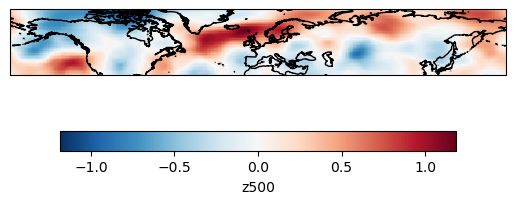

In [22]:
#Useless plot
#toto=z500month.mean('time').plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()},cbar_kwargs={'orientation':'horizontal','shrink':0.8})

#toto.axes.coastlines()

In [11]:
def to_dayofyear(ds):
    year = ds.time.dt.year
    dayofyear = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")
def to_year(ds):
    year = ds.time.dt.year
    # assign new coords
    ds = ds.assign_coords(year=("time", year.data))
    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year"))

index=to_dayofyear(sn).rolling(dayofyear=30).mean()
print(index)
#print(sn.resample(time="Y").rolling(time=30,enter=True).mean())
#index=sn.rolling(time=30).mean().assign_coords({'toto':[i for i in range(1,27)]}).groupby('time.dayofyear')
#print(index[30])
#print(index[30].assign_coords({'time':index[30].toto}))

<xarray.Dataset>
Dimensions:    (year: 26, dayofyear: 366, lat: 180, lon: 360)
Coordinates:
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2015 2016 2017 2018
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    snow       (lat, lon, year, dayofyear) float32 nan nan nan ... nan nan nan


In [27]:
# we compute 7-day and 30-day rolling mean for temperature (weekly anomalies) but nor for snow (to comply with subseasonal forecast context)
#snow=sn.rolling(time=7).mean().dropna(dim='time',how='all')
temp1=temp.rolling(time=30).mean().dropna(dim='time')
temp2=temp.rolling(time=7).mean().dropna(dim='time')
temp1=to_year(temp1.where((temp1.time.dt.month==4)&(temp1.time.dt.day==15)).dropna('time')).rename({'time':'year'})
#temp1=temp.merge(sn.drop_vars(['snow','lat','lon'])).rolling(time=30).construct('window_dim')
print(temp1)

<xarray.Dataset>
Dimensions:    (year: 26)
Coordinates:
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2015 2016 2017 2018
    dayofyear  (year) int64 105 105 105 106 105 105 ... 105 105 105 106 105 105
Data variables:
    t2m        (year) float64 -0.04091 0.1988 -2.584 ... 1.693 2.486 1.887
    z500       (year) float32 18.2 17.8 -67.94 -51.36 ... 32.51 42.79 50.76
    msl        (year) float32 350.5 107.3 -10.72 276.0 ... 16.82 124.4 1.048


In [10]:
test=[xr.corr(index['AO index'].sel({'dayofyear':i}),temp1.z500) for i in range(30,105)]
test2=[xr.corr(index['AO index'].sel({'dayofyear':i}),a.groupby('time.year').mean('time')) for i in range(30,105)]
#print(test)
#print(test2)
cr=xr.Dataset(data_vars={'corr AO z500':(['dayofyear'],test),'corr AO snow PC1':(['dayofyear'],test2)},coords={'dayofyear':[i for i in range(30,105)]})
print(cr)
cr['corr AO z500'].plot(label="corr AO z500")
cr['corr AO snow PC1'].plot(label='corr AO snow PC1')
plt.legend()

KeyError: 'AO index'

In [28]:
print(temp1)

<xarray.Dataset>
Dimensions:    (year: 26)
Coordinates:
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2015 2016 2017 2018
    dayofyear  (year) int64 105 105 105 106 105 105 ... 105 105 105 106 105 105
Data variables:
    t2m        (year) float64 -0.04091 0.1988 -2.584 ... 1.693 2.486 1.887
    z500       (year) float32 18.2 17.8 -67.94 -51.36 ... 32.51 42.79 50.76
    msl        (year) float32 350.5 107.3 -10.72 276.0 ... 16.82 124.4 1.048


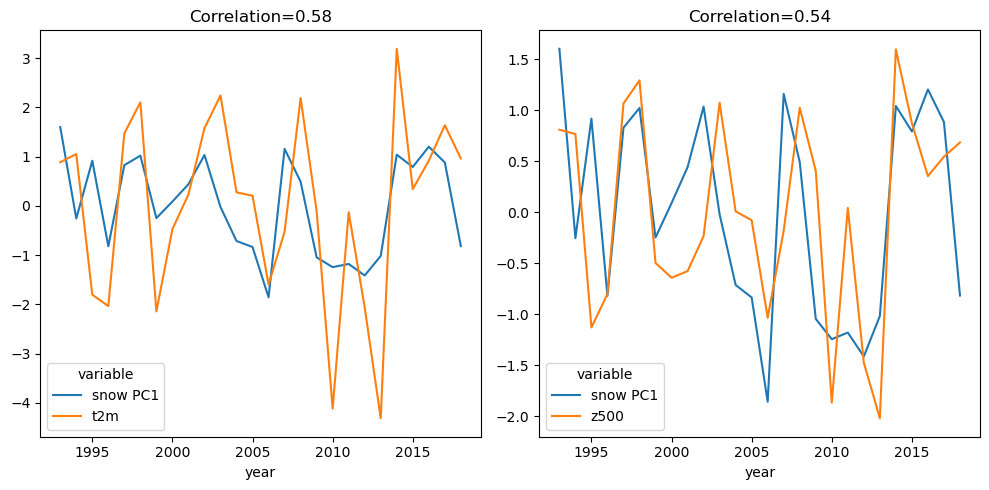

In [15]:
#Same as above but after linearly detrending temperature time series
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
detrended_temp=detrend_dim(da=temp1.t2m,dim='year').rename('t2m')
detrended_z=detrend_dim(da=ts,dim='year').rename('z500')

#we correlate yearly averages of the Principal component time series of EOF1 and the temperature index
c=xr.corr(detrended_temp,a.groupby('time.year').mean('time'))
c2=xr.corr(detrended_z,a.groupby('time.year').mean('time'))
fig,axs = plt.subplots(ncols=2,figsize=(10, 5))
t=xr.combine_by_coords([detrended_temp,a.groupby('time.year').mean('time')])
t.rename({'pcs':'snow PC1'}).to_array().plot.line(ax=axs[0],x='year')
axs[0].set_title("Correlation="+str(np.round(c.values,2)))
t=xr.combine_by_coords([detrended_z,a.groupby('time.year').mean('time')])
t.rename({'pcs':'snow PC1'}).to_array().plot.line(ax=axs[1],x='year')
axs[1].set_title("Correlation="+str(np.round(c2.values,2)))
fig.tight_layout()

/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


Text(0.5, 1.0, 'Correlation of average 18 March-15 April msl anomaly (ERA5) box with PC1 of 17 Feb- 18 March snow depth water equivalent (ERA5-Land)')

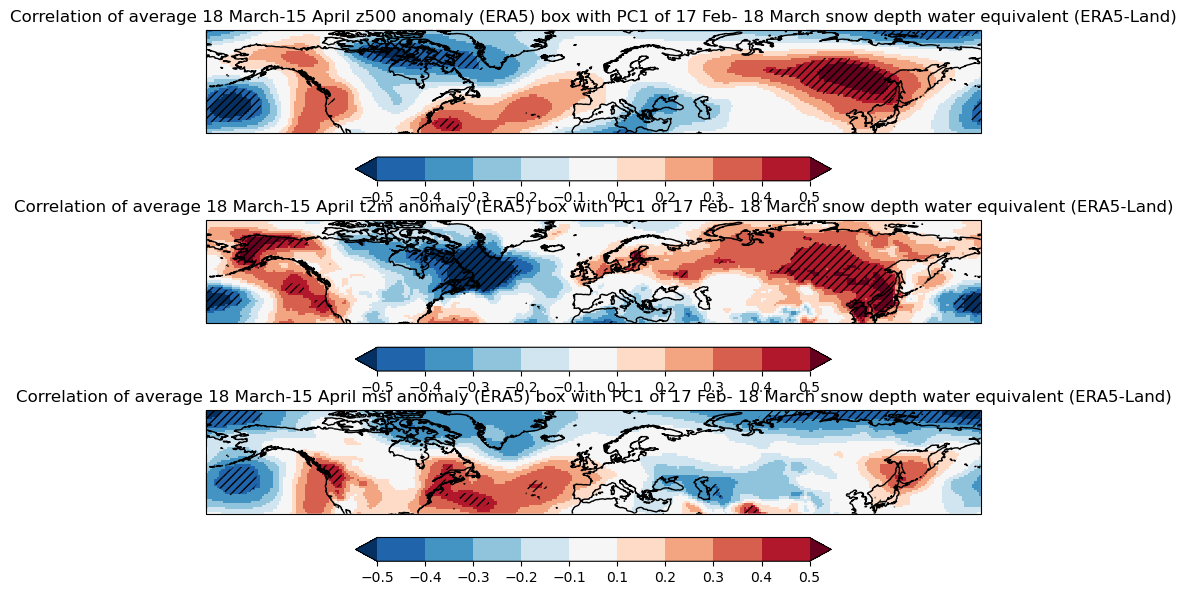

In [32]:
#Plot the correlation and hatch significant values at the 0.05% confidence level
#between PC1 of 17 Feb to 18 March Eurasian snow and 18March to 15April grid point z500 
zmonth=temp0.where(((temp0.time.dt.month==3)&(temp0.time.dt.day>=18))|((temp0.time.dt.month==4)&(temp0.time.dt.day<=15))).dropna(dim='time',how='all')
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
fig,axs = plt.subplots(nrows=3,figsize=(10, 7),subplot_kw=dict(projection=ccrs.PlateCarree()))                      
p=xs.pearson_r(zmonth.z500.groupby('time.year').mean('time'),a.groupby('time.year').mean('time'),dim='year').sel(lat=slice(0,80)).plot(ax=axs[0],x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
s=xs.pearson_r_eff_p_value(zmonth.z500.groupby('time.year').mean('time'),a.groupby('time.year').mean('time'),dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
#pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.set_title("Correlation of average 18 March-15 April z500 anomaly (ERA5) box with PC1 of 17 Feb- 18 March snow depth water equivalent (ERA5-Land)")
p=xs.pearson_r(zmonth.t2m.groupby('time.year').mean('time'),a.groupby('time.year').mean('time'),dim='year').sel(lat=slice(0,80)).plot(ax=axs[1],x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
s=xs.pearson_r_eff_p_value(zmonth.t2m.groupby('time.year').mean('time'),a.groupby('time.year').mean('time'),dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
#pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.set_title("Correlation of average 18 March-15 April t2m anomaly (ERA5) box with PC1 of 17 Feb- 18 March snow depth water equivalent (ERA5-Land)")

p=xs.pearson_r(zmonth.msl.groupby('time.year').mean('time'),a.groupby('time.year').mean('time'),dim='year').sel(lat=slice(0,80)).plot(ax=axs[2],x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
s=xs.pearson_r_eff_p_value(zmonth.msl.groupby('time.year').mean('time'),a.groupby('time.year').mean('time'),dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
#pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.set_title("Correlation of average 18 March-15 April msl anomaly (ERA5) box with PC1 of 17 Feb- 18 March snow depth water equivalent (ERA5-Land)")

/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


Text(0.5, 1.0, 'Correlation of average 18 March-15 April 2m temperature anomaly (ERA5) averaged over the red box with average 17 Feb- 18 March snow depth water equivalent (ERA5-Land)')

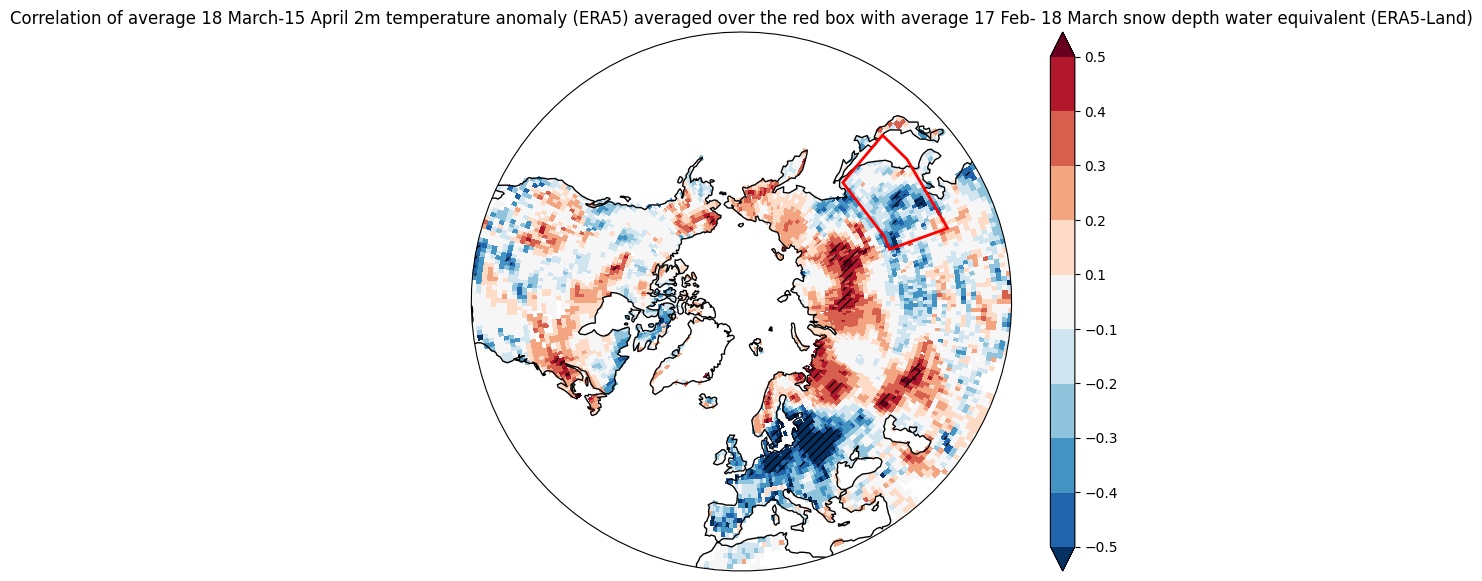

In [67]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
#between yearly averages of 17 Feb to 18 March snow and 18March to 15April Red box 2m Temperature 
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
fig = plt.figure(figsize=(10, 7))
p=xs.pearson_r(snmonth.snow.groupby('time.year').mean('time'),detrended_temp,dim='year').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
s=xs.pearson_r_eff_p_value(snmonth.snow.groupby('time.year').mean('time'),detrended_temp,dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[255, 39], width=35, height=11, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of average 18 March-15 April 2m temperature anomaly (ERA5) averaged over the red box with average 17 Feb- 18 March snow depth water equivalent (ERA5-Land)")

In [30]:
# Same idea as bove, but mimicking subseasonal forecasting
#We keep only the 25 Feb, 4 March, 11 March and 18 March for snow depth water equivalent anomalies
sn=sn.where(((sn.time.dt.month==2) & (sn.time.dt.day==25)) | ((sn.time.dt.month==3) & (np.isin(sn.time.dt.day,[4,11,18])))).dropna(dim='time',how='all')
#We keep for each year the 4 corresponding 7-day rolling mean temperature 25 days after the snow dates
test_temp=temp2.shift(time=-25).reindex({'time':sn.time}) #Reminder: temp2 = 7-day rolling mean temperature. 

/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


Text(0.5, 1.0, "Correlation of 'week 4' 2m temperature anomaly (ERA5) averaged over the red box with initial snow depth water equivalent (ERA5-Land)")

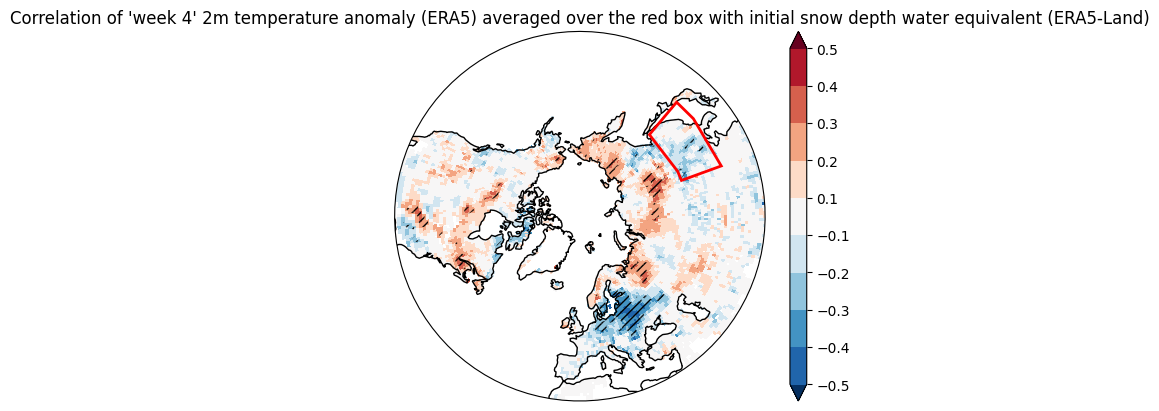

In [31]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
p=xs.pearson_r(sn.snow,test_temp.t2m,dim='time').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
s=xs.pearson_r_eff_p_value(sn.snow,test_temp.t2m,dim='time').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[250, 37], width=40, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of 'week 4' 2m temperature anomaly (ERA5) averaged over the red box with initial snow depth water equivalent (ERA5-Land)")

Text(0.5, 1.0, 'Mean snow evolution btwn 25 Feb.and 18 March')

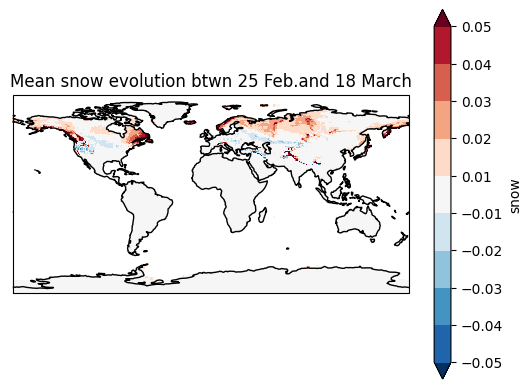

In [32]:
#Not very informative plot: Mean snow depth evolution btwn 25 Feb.and 18 March
ref='era5land'
variables=['sd']
snfull=rd.read_ref(path_snow,variables,ref).compute()
snfull=snfull.rename({'sd':'snow'})

levels = [np.round(x,2) for x in np.arange(-0.05,0.06,0.01) ]
levels.remove(0)
g=snfull.where((snfull.time.dt.month==3) & (snfull.time.dt.day==18)).dropna(dim='time',how='all')
f=snfull.where((snfull.time.dt.month==2) & (snfull.time.dt.day==25)).dropna(dim='time',how='all')
#a.sd.mean('time').plot(levels=[np.round(x,2) for x in np.arange(0,0.55,0.05)])
p=(g.snow.mean('time')-f.snow.mean('time')).plot(levels=levels,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()))
p.axes.coastlines()
plt.title("Mean snow evolution btwn 25 Feb.and 18 March")